In [1]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.planet import Planet


%load_ext autoreload
%autoreload 2

## Initialise `datacube` object
The main parameters are a 
* 2D** wavelength vector (K_orders, N_pixels)

* 3D flux matrix (K_orders, M_frames, N_pixels)

** assuming a common wavelength grid for each order, see Notebook XX for more details

In [2]:
# get example data
# or pass your own data with the required shape

In [3]:
file = '/home/dario/AstronomyLeiden/MRP/redcross/examples/data/spectra_harpsn.fits'

with fits.open(file) as hdul:
#     hdul.info()
    header = hdul[1].data
    wave = hdul[2].data
    flux = hdul[3].data
    
print('Header contains: ', header.columns.names)    
dc = Datacube(wlt=wave, flux=flux)
# Alternatively, pass dictionary as **argument to Datacube()
dc.airmass, dc.BERV, dc.MJD = header.airmass, header.BERV, header.MJD 

print('Cube shape = ', dc.shape)

Header contains:  ['airmass', 'BERV', 'MJD']
Cube shape =  (69, 247, 4096)


### Select single order
Work with a single order "dco = DataCubeOrder" by passing an integer (or list) to the function `datacube.order(i)`

* Display stacked spectra as an image --> `dco.imshow()`

* Plot the time-average (i.e. master spectrum) --> `dco.plot()`

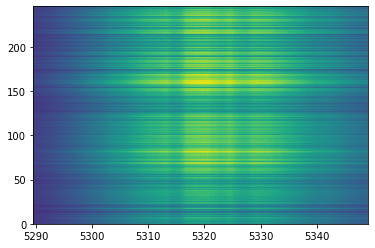

In [4]:
dco = dc.order(42)

# utility function to display the datacube
# y-axis: Frame number, x-axis: Wavelength (A)
dco.imshow()

### Display all orders
For each order, plot the master spectrum

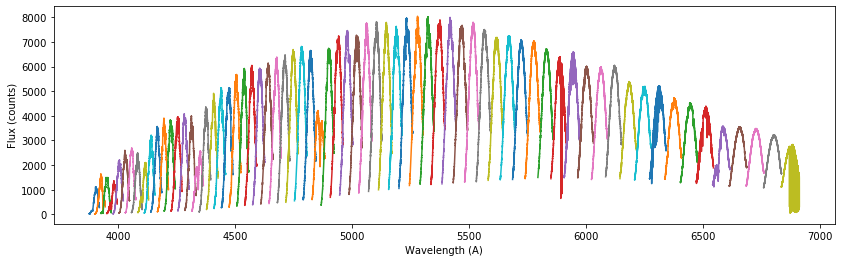

In [5]:
fig, ax = plt.subplots(1, figsize=(14,4))
for o in range(dc.nOrders):
    dco = dc.order(o).plot(ax=ax) # .plot() displays the time-average i.e. master-spectrum

ax.set(xlabel='Wavelength (A)', ylabel='Flux (counts)')
plt.show()

### Basic reduction (for a single order)
The in-built functions can apply the following reduction steps directly to the datacube object by simply passing an plt.ax() object as an (optional) argument.
Let's display the cube at each stage. A very simple reduction routine is:
* `normalise`: Divide each frame by its median flux
* `airmass_detrend`: For each wavelength channel, divide the flux by a second-order polynomial fit between airmass and flux depth
* `high_pass_gaussian`: Keep only high-frequency signals (< window) by dividing each frame by a low-pass gaussian filter

More advanced reduction routines are discussed in other Notebooks (including `remove_continuum`, `SysRem`, `sigma_clip`, `mask_cols`, ...)

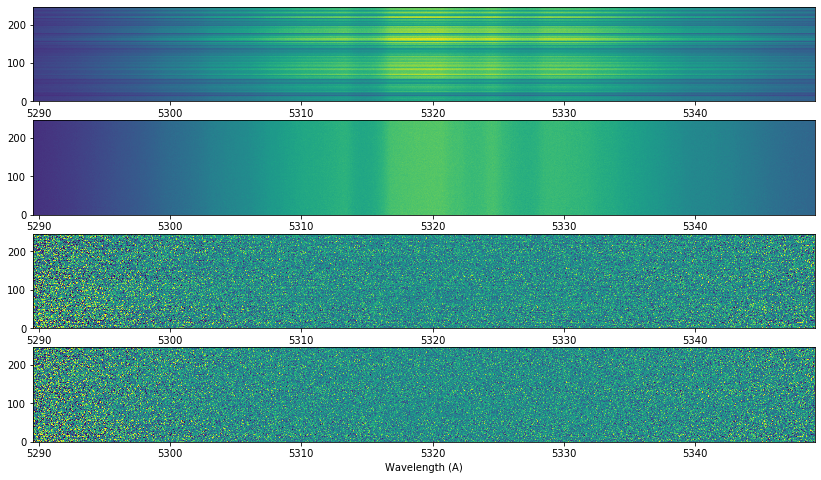

In [6]:
fig, ax = plt.subplots(4,figsize=(14,8))

# First select an order
dco = dc.order(42)
dco.imshow(ax=ax[0])

# Normalise
dco.normalise(ax=ax[1])

# Airmass detrend
dco.airmass_detrend(ax=ax[2])

# High-pass filter
dco.high_pass_gaussian(15, ax=ax[3]) # window in [pixels]

ax[3].set(xlabel='Wavelength (A)')
plt.show()

### Reduction routine for a set of orders
Loop over different orders and store the flattened data in a "merged datacube" 

Reduced cube shape = (247, 36864)


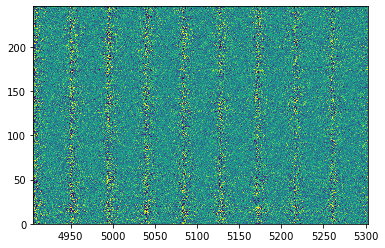

In [7]:
orders = np.arange(33,42)
wave_list = []
flux_list = []
for o in orders:
    print('Order {:}/{:}'.format(o, orders[0]+orders.size), end='\r')
    dco = dc.order(o)
    dco = dco.normalise().airmass_detrend().high_pass_gaussian(15)
    wave_list.append(dco.wlt)
    flux_list.append(dco.flux)
    
dcm = Datacube(wlt=np.hstack(wave_list), flux=np.hstack(flux_list)) # concatenate orders
dcm.imshow() # it should look "very" homogeneous ---> noise pattern
# the *noisy stripes* are the left part of the detector of each order
print('Reduced cube shape = {:}'.format(dcm.shape)) 
# the number of frames is the same 
# the new wave vector is the added wave-vectors of each order

### Load atmospheric template

Filename: data/wasp189_fe_4000k.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (72646,)   float64   
  1                1 ImageHDU         6   (72646,)   float64   


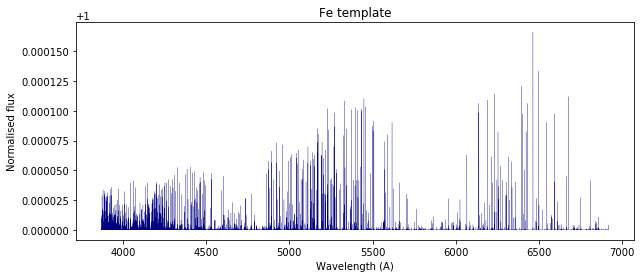

In [8]:
template_path = 'data/wasp189_fe_4000k.fits'
with fits.open(template_path) as hdul:
    hdul.info()
    twave, tflux = hdul[0].data,  hdul[1].data

# wavelength must be in the same units as data (A), 
# multiply by 10 to go from nm to A
# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux)

fig, ax = plt.subplots(1, figsize=(10,4))
ax.plot(template.wlt, template.flux, c='navy', lw=0.2)
ax.set(xlabel='Wavelength (A)', ylabel='Normalised flux', title='Fe template')
plt.show()

### Shift to stellar frame
Apply the RV-barycentric correction by using the `BERV` header values. Every frame is shifted accoring to its BERV value and the data is resampled onto the new (shifted) wave vector.

In [9]:
dcm.to_stellar_frame(dc.BERV)

## Cross-correlation

Compute the cross-correlation function (CCF) for each frame along the RV lag-vector to build a 2D CCF
> ```CCF.shape = (nFrames, nRV)```

The default definition of the CCF is
$$ 
CCF_{ij} = \frac{data_i \times template_j}{\sigma_i^2}
$$
where $i$ = 1,.., nFrame and $j$ = min(RV),.., max(RV) and $\sigma_i$ is the noise of each pixel channel (column).

In [10]:
# define radial velocity lag vector
dRV = 1.6 # the RV-step should be larger (or equal) to the instrument's resolution (in km/s)
# HARPS-N: R ~ 115,000 ---> delta_RV ~ 1.6 km/s
RVt = np.arange(-350,351, dRV) 

# Define CCF object
ccf = CCF(rv=RVt, template=template)
ccf.run(dcm, weighted=True)

## Load planet data
To shift the CCF to the planetary rest-frame we load the planet's orbital parameters.
### 1. from a file (see `WASP189.dat` for an example)
 ```
 planet_file = 'data/wasp33.dat' 
 planet = Planet(file=planet_file) 

 ```

In [11]:
!cat data/WASP189.dat

# Planet properties for WASP-189b
# IMPORTANT: Introduce values in the required units
2.7240338 	# Orbital period [day]
0.0497 	# Semi-major axis [AU]
84.32 		# Inclination [deg]
-20.82 	# Systemic velocity [km/s]
2456706.4558 	# Primary transit time [BJD], Yan+2020
4.351199 	# Transit duration (T_14) [hours]



### 2. manually passing a dictionary

In [12]:
planet_dict = {'P':2.7240338, 'a':0.0497, 'i':84.32, 'v_sys':-20.82, 'Tc_jd':2456706.4558,
               'RA_DEG': 225.68695,'DEC_DEG': -3.0313833}
planet = Planet(**planet_dict)
planet.BERV = dc.BERV
planet.MJD = dc.MJD

### Shift the CCF to the planetary rest frame

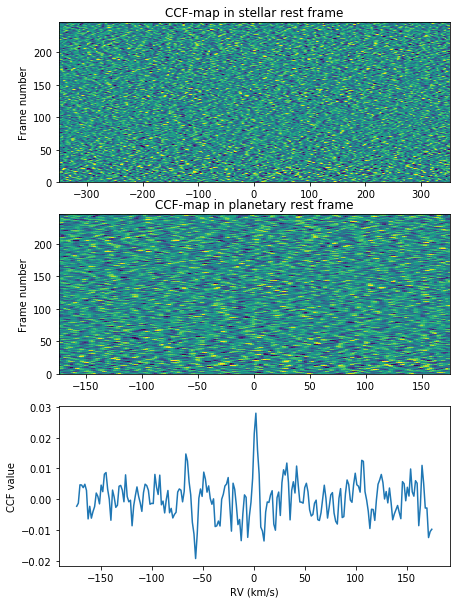

In [13]:
# Plot results from CCF in stellar and planetary frame
fig, ax = plt.subplots(3,1,figsize=(7,10))

ccf.imshow(ax=ax[0])
ccf_planet = ccf.to_planet_frame(planet, ax=ax[1])
ax[2].plot(ccf_planet.rv, np.median(ccf_planet.flux, axis=0))

ax[0].set(ylabel='Frame number', title='CCF-map in stellar rest frame')
ax[1].set(ylabel='Frame number', title='CCF-map in planetary rest frame')
ax[2].set(xlabel='RV (km/s)', ylabel='CCF value')
plt.show()

## Kp-Vsys map

This map is constructed by **adding** the values of the CCF along different paths by changing the $K_p$ and $V_{sys}$ values.
The planet signal should appear around $V_{sys} \sim $ 0 km/s if the passed $V_{sys}$ value is correct. The $K_p$ vector is automatically generated around the expected $K_p$ (with the planet orbital parameters):

$$ v_{orb} = 2\pi a / P \\ K_p = v_{orb} / \sin{i} $$

The instantaneous planet velocity is (in the **obs**erver's and **planet**'s reference frame):


$$ RV(t)_{obs} = V_{sys} + BERV + K_p \sin{\phi(t)} \\
RV(t)_{planet} = K_p \sin{\phi(t)} = RV(t)_{obs} - (V_{sys} + BERV)$$ 


where $\phi$ is the phase ($\phi = 0$ at mid-transit `planet.Tc`).

Horizontal slice at Kp = 197.5 km/s
Vertical slice at Vrest = 1.6 km/s


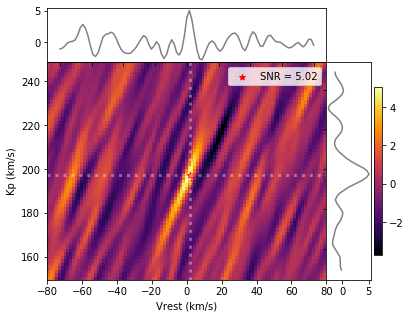

Expected planet Kp = 199.5 km / s


In [14]:
dkp, kp_amp = dRV, 50 # km/s
vrest_amp, dvrest = 80, dRV # km /s
kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)
kpv.run()
kpv.fancy_figure()
plt.show()
print('Expected planet Kp = {:.1f}'.format(planet.Kp))